In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#read the reviews
import pandas as pd
gdrive_path = '/content/drive/MyDrive/mydata/'
data = pd.read_csv(f"{gdrive_path}IMDB_Dataset_label.csv")

data.sample(n=10)

,Unnamed: 0,review,sentiment,label
20679,20679,I am very interested in animal children and I ...,negative,0
48583,48583,This is the final episode we deserved. At the ...,positive,1
39480,39480,"The film is annoying.<br /><br />Technically, ...",negative,0
38444,38444,Spirit of a murdered high school geek animates...,negative,0
26316,26316,"i love horror films, low budget, 50's, 60's, 7...",negative,0
49474,49474,"So, I got a hold of this as an assignment for ...",negative,0
43637,43637,"""The Last Wave"" is one of those movies that re...",positive,1
38968,38968,"When I first saw this movie,I also expected ""o...",positive,1
25167,25167,"It ran 8 seasons, but it's first, in early 195...",positive,1
36742,36742,Here is one the entire family will enjoy... ev...,positive,1


In [4]:
data.groupby('sentiment').describe()

Unnamed: 0                                                    \
               count         mean           std  min      25%      50%   
sentiment                                                                
negative     25000.0  24964.07768  14461.920812  3.0  12403.5  24940.0   
positive     25000.0  25034.92232  14406.028970  0.0  12577.0  25039.0   

                                label                                     
                75%      max    count mean  std  min  25%  50%  75%  max  
sentiment                                                                 
negative   37482.50  49999.0  25000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
positive   37524.25  49995.0  25000.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [5]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [6]:
# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, BatchNormalization, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
from collections import Counter
import time


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pickle
import itertools

In [7]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [9]:
%%time
data.review = data.review.apply(lambda x: preprocess(x))

CPU times: user 31.2 s, sys: 78.6 ms, total: 31.3 s
Wall time: 38.2 s


In [10]:
data.sample(n=10)

,Unnamed: 0,review,sentiment,label
20905,20905,cement bad movie bad cop penn bad attitude bad...,negative,0
7112,7112,worst movie ever seen seen allot acting horrib...,negative,0
10058,10058,saw movie netflix intrigued way movie describe...,positive,1
29600,29600,2 morning one saturday years ago various reaso...,positive,1
34242,34242,movie lot fun seen couple times always somethi...,positive,1
49204,49204,returned showing left foot public library emot...,positive,1
42515,42515,accidentally stumbled across script textual fo...,negative,0
8971,8971,remember first heard jack frost video ezy mira...,negative,0
25690,25690,find rather useless comment movie simplest rea...,negative,0
30824,30824,one funniest shows tv today hits mark 99 time ...,positive,1


In [11]:
# split data into train and test set
from sklearn.model_selection import train_test_split

X = data['review'].values
y = data['sentiment'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
%%time
documents = [_text.split() for _text in data.review]

CPU times: user 643 ms, sys: 151 ms, total: 794 ms
Wall time: 793 ms


In [13]:
# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 32
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "positive"
NEGATIVE = "negative"
NEUTRAL = "neutral"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "Sentiment_bilstm_w2vSG.sav"
WORD2VEC_MODEL = "modelSG.w2v"
TOKENIZER_MODEL = "lstm_w2v_tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [14]:
# train a Skip Gram model
w2vmodel_SG = gensim.models.Word2Vec(documents, vector_size = W2V_SIZE, window = W2V_WINDOW, min_count = W2V_MIN_COUNT, workers = 8, sg = 1)

In [15]:
SG_words = w2vmodel_SG.wv.index_to_key
SG_vocab_size_wv = len(SG_words)
print("Vocabulary size for Skip Gram:", SG_vocab_size_wv)

Vocabulary size for Skip Gram: 28058


In [16]:
# Obtain words most similar to movie

w2vmodel_SG.wv.most_similar("movie")

[('film', 0.781706690788269),
 ('havent', 0.7083489298820496),
 ('hesitated', 0.7015929818153381),
 ('sequal', 0.6986175179481506),
 ('couldnt', 0.6982324719429016),
 ('strangeland', 0.685479462146759),
 ('summery', 0.6818343997001648),
 ('interferencia', 0.6811971664428711),
 ('lousiest', 0.6811666488647461),
 ('wouldnt', 0.6715007424354553)]

In [17]:
# Tokenizing

%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.review)

CPU times: user 4.42 s, sys: 129 ms, total: 4.55 s
Wall time: 4.47 s


In [18]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 100947


In [19]:
# Padding

%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=SEQUENCE_LENGTH)

CPU times: user 4.49 s, sys: 61.8 ms, total: 4.55 s
Wall time: 4.64 s


In [20]:
# Have the option for neutral sentiment

labels = data.sentiment.unique().tolist()
labels.append("neutral")
labels

['positive', 'negative', 'neutral']

In [21]:
# Train the encoder

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(data.sentiment.tolist())

y_train = encoder.transform(Y_train.tolist())
y_test = encoder.transform(Y_test.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (40000, 1)
y_test (10000, 1)


In [22]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (40000, 300)
y_train (40000, 1)

x_test (10000, 300)
y_test (10000, 1)


In [23]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [24]:
SG_embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
     if word in w2vmodel_SG.wv:
            SG_embedding_matrix[i] = w2vmodel_SG.wv[word]
print(SG_embedding_matrix.shape)

(100947, 300)


In [25]:
SG_embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[SG_embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [26]:
# Create BiLSTM model

SG_model = Sequential()
SG_model.add(SG_embedding_layer)
SG_model.add(Dropout(0.5))
SG_model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
SG_model.add(Dense(1, activation='sigmoid'))

SG_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          30284100  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 bidirectional (Bidirection  (None, 200)               320800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 30605101 (116.75 MB)
Trainable params: 321001 (1.22 MB)
Non-trainable params: 30284100 (115.52 MB)
_________________________________________________________________


In [27]:
SG_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [28]:
# Train and save the BiLSTM, encoder, tokenizer and word2vec (Skip gram)

%%time
history = SG_model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

import pickle

SG_model.save(KERAS_MODEL)
w2vmodel_SG.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)


Epoch 1/32
36/36 [==============================] - 107s 3s/step - loss: 0.5165 - accuracy: 0.7521 - val_loss: 0.4425 - val_accuracy: 0.8070 - lr: 0.0010
Epoch 2/32
36/36 [==============================] - 91s 3s/step - loss: 0.3737 - accuracy: 0.8393 - val_loss: 0.3205 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 3/32
36/36 [==============================] - 94s 3s/step - loss: 0.3467 - accuracy: 0.8531 - val_loss: 0.3850 - val_accuracy: 0.8665 - lr: 0.0010
Epoch 4/32
36/36 [==============================] - 90s 3s/step - loss: 0.3215 - accuracy: 0.8650 - val_loss: 0.3417 - val_accuracy: 0.8792 - lr: 0.0010
Epoch 5/32
36/36 [==============================] - 91s 2s/step - loss: 0.3269 - accuracy: 0.8628 - val_loss: 0.3476 - val_accuracy: 0.8695 - lr: 0.0010
Epoch 6/32
36/36 [==============================] - 92s 3s/step - loss: 0.3085 - accuracy: 0.8694 - val_loss: 0.3254 - val_accuracy: 0.8823 - lr: 0.0010
Epoch 7/32
36/36 [==============================] - 92s 3s/step - loss: 0.3032 - 

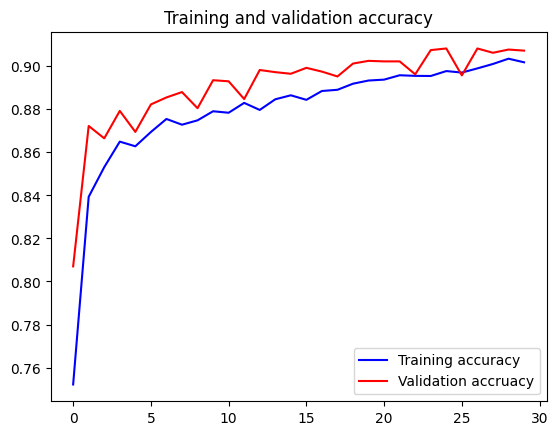

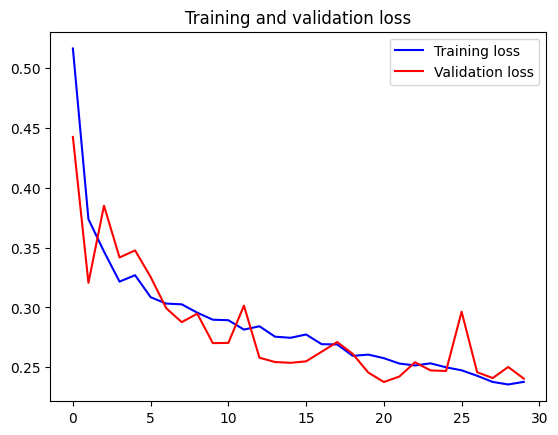

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accruacy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
%%time
score = SG_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 2s 214ms/step - loss: 0.2355 - accuracy: 0.9063

ACCURACY: 0.9063000082969666
LOSS: 0.2355332225561142
CPU times: user 1.95 s, sys: 302 ms, total: 2.25 s
Wall time: 2.32 s


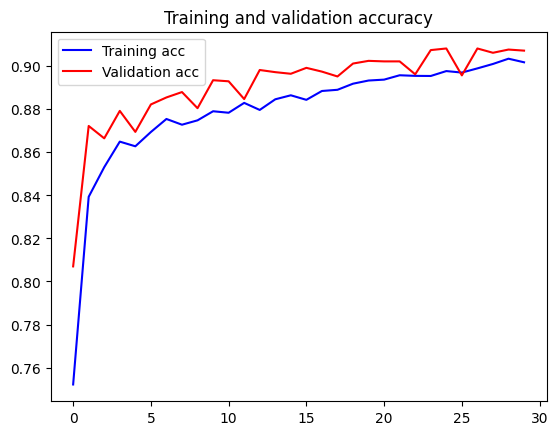

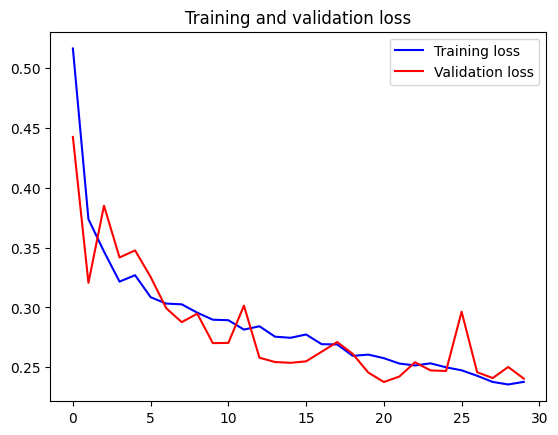

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [33]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = SG_model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [34]:
predict("I think this is a very great movie.")

1/1 [==============================] - 1s 552ms/step


{'label': 'positive',
 'score': 0.734363317489624,
 'elapsed_time': 0.6002628803253174}

In [35]:
%%time
y_pred_1d = []
y_test_1d = list(Y_test)
scores = SG_model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

2/2 [==============================] - 2s 350ms/step
CPU times: user 1.37 s, sys: 542 ms, total: 1.91 s
Wall time: 1.9 s


In [36]:
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

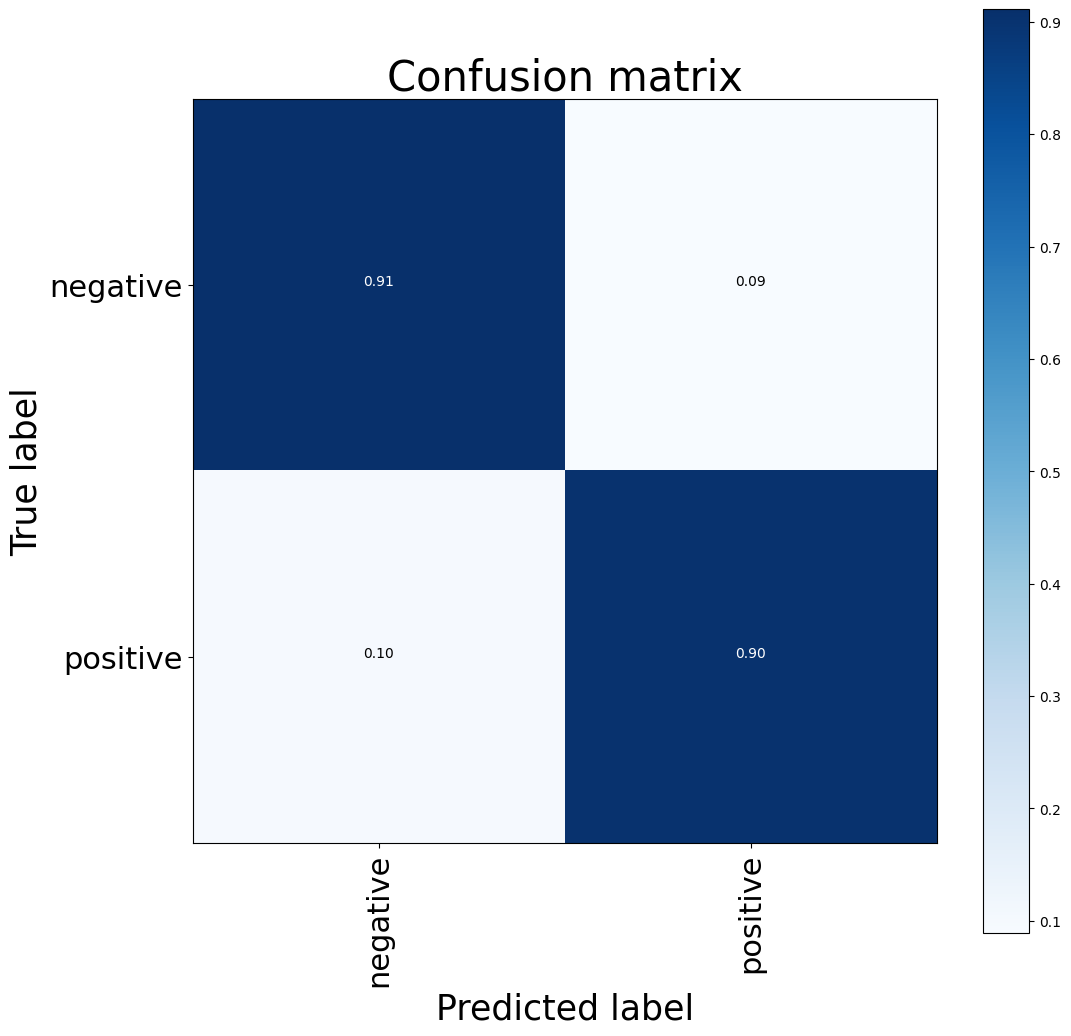

CPU times: user 432 ms, sys: 258 ms, total: 690 ms
Wall time: 420 ms


In [37]:
%%time
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=np.unique(Y_train), title="Confusion matrix")
plt.show()

In [38]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    negative       0.90      0.91      0.91      4961
    positive       0.91      0.90      0.91      5039

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [40]:
import pickle

gdrive_path = '/content/drive/MyDrive/mydata/ModelFolder2/'
KERAS_MODEL = "Sentiment_bilstm_w2vSG.sav"
WORD2VEC_MODEL = "modelSG.w2v"
TOKENIZER_MODEL = "lstm_w2v_tokenizerSG.pkl"
ENCODER_MODEL = "encoderSG.pkl"
SG_model.save(f"{gdrive_path}{KERAS_MODEL}")
w2vmodel_SG.save(f"{gdrive_path}{WORD2VEC_MODEL}")
pickle.dump(tokenizer, open(f"{gdrive_path}{TOKENIZER_MODEL}", "wb"), protocol=0)
pickle.dump(encoder, open(f"{gdrive_path}{ENCODER_MODEL}", "wb"), protocol=0)